# Regression Using XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb 
warnings.filterwarnings('ignore')

## Importing Pre-processed Data

In [2]:
df_new = pd.read_pickle(r'C:\Users\nishi\Desktop\EECS 731 - Data Science\Project\df_new.pkl')

In [3]:
df_new.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,total_amount,payment_type,trip_type,trip_duration,month,day,total_custom,weekend_Trip,hour,airport
0,2017-12-31 23:55:09,2017-12-31 23:59:14,1,17,61,1,1.1,5.5,0.5,0.5,...,6.80,2,1.0,4.083333,12,6,6.80,1,23,0
1,2017-12-31 23:30:36,2017-12-31 23:37:20,1,61,49,1,1.1,6.5,0.5,0.5,...,7.80,2,1.0,6.733333,12,6,7.80,1,23,0
2,2017-12-31 23:02:26,2017-12-31 23:19:37,1,228,188,1,4.1,15.5,0.5,0.5,...,20.15,1,1.0,17.183333,12,6,20.15,1,23,0
3,2017-12-31 23:12:24,2017-12-31 23:16:55,1,228,26,1,0.8,5.0,0.5,0.5,...,6.30,2,1.0,4.516667,12,6,6.30,1,23,0
4,2017-12-31 23:53:11,2017-12-31 23:55:40,1,225,225,1,0.5,4.0,0.5,0.5,...,5.30,2,1.0,2.483333,12,6,5.30,1,23,0


## Shuffling data

In [4]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

## Different Models with different features for accuracy comparasion

In [5]:
# Creating a dataframes for model testing. Models cannot parse datetime columns, so have to drop them

# Models with trip_distance & trip_duration
df_1 = df_new[['trip_distance','trip_duration','airport','fare_amount']]

# Models without trip_distance & trip_duration
df_2 = df_new[['airport','RatecodeID','payment_type','DOLocationID','trip_type','passenger_count','PULocationID','hour','day','weekend_Trip','month','fare_amount']]

# Models with only trip_distance
df_3 = df_new[['trip_distance','airport','RatecodeID','payment_type','DOLocationID','trip_type','passenger_count','PULocationID','hour','day','fare_amount']]


## Splitting the data into Training and Testing

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

features_1 = df_1.drop(['fare_amount'], axis = 1)
labels_1 = df_1[['fare_amount']]

features_2 = df_2.drop(['fare_amount'], axis = 1)
labels_2 = df_2[['fare_amount']]

features_3 = df_3.drop(['fare_amount'], axis = 1)
labels_3 = df_3[['fare_amount']]

In [7]:
# Split the data into training and testing sets

train_features_1, test_features_1, train_labels_1, test_labels_1 = train_test_split(features_1, labels_1, test_size = 0.10, random_state = 42)
train_features_2, test_features_2, train_labels_2, test_labels_2 = train_test_split(features_2, labels_2, test_size = 0.10, random_state = 42)
train_features_3, test_features_3, train_labels_3, test_labels_3 = train_test_split(features_3, labels_3, test_size = 0.10, random_state = 42)


In [8]:
print('Training Features Shape:', train_features_1.shape)
print('Training Labels Shape:', train_labels_1.shape)
print('Testing Features Shape:', test_features_1.shape)
print('Testing Labels Shape:', test_labels_1.shape)

Training Features Shape: (2024739, 3)
Training Labels Shape: (2024739, 1)
Testing Features Shape: (224972, 3)
Testing Labels Shape: (224972, 1)


In [9]:
dtrain_1 = xgb.DMatrix(train_features_1, label=train_labels_1)
dtrain_2 = xgb.DMatrix(train_features_2, label=train_labels_2)
dtrain_3 = xgb.DMatrix(train_features_3, label=train_labels_3)
dtest_1 = xgb.DMatrix(test_features_1)
dtest_2 = xgb.DMatrix(test_features_2)
dtest_3 = xgb.DMatrix(test_features_3)

# Using XGBoost for prediction

In [10]:
#set parameters for xgboost
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
         }
num_rounds = 50

In [11]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf1 = xgb.train(params,dtrain_1,num_rounds)
rf2 = xgb.train(params,dtrain_2,num_rounds)
rf3 = xgb.train(params,dtrain_3,num_rounds)

Wall time: 1min 57s


# Predicting from Input

In [12]:
prediction_1 = rf1.predict(dtest_1)
prediction_2 = rf2.predict(dtest_2)
prediction_3 = rf3.predict(dtest_3)

In [13]:
result_1 = test_features_1
result_2 = test_features_2
result_3 = test_features_3

## Creating Results

In [14]:
result_1['actual_fare'] = test_labels_1[['fare_amount']]
result_2['actual_fare'] = test_labels_2[['fare_amount']]
result_3['actual_fare'] = test_labels_3[['fare_amount']]

result_1['predicted_fare'] = prediction_1
result_2['predicted_fare'] = prediction_2
result_3['predicted_fare'] = prediction_3


result_1['difference'] = abs(result_1['predicted_fare']-result_1['actual_fare'])
result_2['difference'] = abs(result_2['predicted_fare']-result_2['actual_fare'])
result_3['difference'] = abs(result_3['predicted_fare']-result_3['actual_fare'])

## Model Accuracy

### Models with both trip_distance & trip_duration
Model_1 = {'trip_distance','trip_duration','airport','fare_amount'}

In [15]:
print("Model_1 Accuracy % : " +str((result_1[result_1['difference'] < 1].shape[0]/result_1.shape[0]) * 100)[:5])

Model_1 Accuracy % : 94.30


### Models without trip_distance & trip_duration

Model_2 = {'airport','RatecodeID','payment_type','DOLocationID','trip_type','passenger_count','PULocationID','hour','day','weekend_Trip','month','fare_amount'}  

In [16]:
print("Model_2 Accuracy % : " +str((result_2[result_2['difference'] < 1].shape[0]/result_2.shape[0]) * 100)[:5])

Model_2 Accuracy % : 30.17



### Models with only trip_distance

Model_3 = {'airport','RatecodeID','payment_type','DOLocationID','trip_type','passenger_count','PULocationID','hour','day','fare_amount'}  

In [17]:
print("Model_3 Accuracy % : " +str((result_3[result_3['difference'] < 1].shape[0]/result_3.shape[0]) * 100)[:5])

Model_3 Accuracy % : 65.37


In [18]:
d = pd.DataFrame(columns=['Models','Accuracy'])
d['Models'] = ['Model_1', 'Model_2', 'Model_3']
d['Accuracy'].loc[[0]] = ((result_1[result_1['difference'] < 1].shape[0]/result_1.shape[0]) * 100)
d['Accuracy'].loc[[1]] = ((result_2[result_2['difference'] < 1].shape[0]/result_2.shape[0]) * 100)
d['Accuracy'].loc[[2]] = ((result_3[result_3['difference'] < 1].shape[0]/result_3.shape[0]) * 100)


# Results

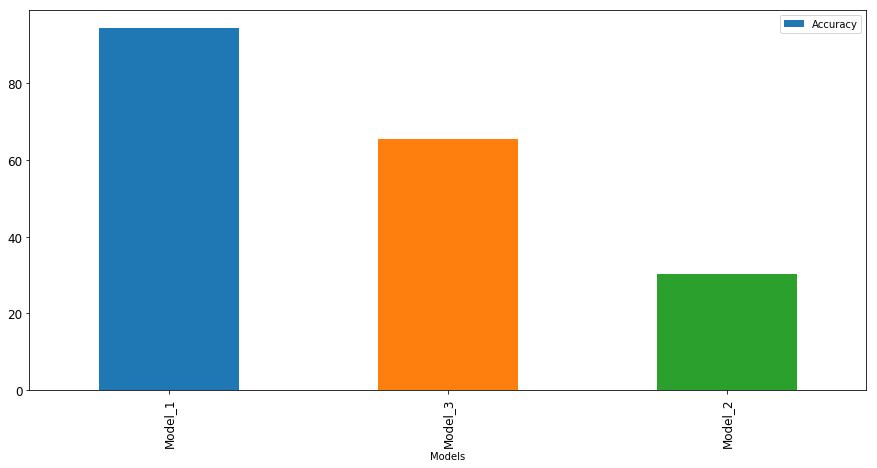

In [19]:
d.sort_values(by=['Accuracy'], ascending=False).plot.bar(x='Models', y='Accuracy',figsize=(15,7), fontsize=12)